# Retail Promotion Classification-Prediction Problem
## Vasundhara Bagchi, Elizabeth Slesarev, and Paul Beltran 

Through this project, we are aiming to use retail sales data to understand how the stores could run a promotional campaign targeting customers who spend a lot of money in a certain category. 

This project would allow retail stores, particularly one without a lot of resources dedicated to promotional material, to optimize their promotional campaigns by identifying the most effective customer profiles to target with their marketing efforts. This approach can save retailers significant resources and effort by avoiding a standarized approach to promotions, which can be less effective and less efficient. Instead, stores can target specific customer segments based on their preferences in shopping categories, past purchasing behaviors, and other factors to maximize the effectiveness of their promotions.

This particular dataset contains data from various age groups and genders several categories from 10 shopping malls in Instanbul, Turkey. 

Data Source: https://www.kaggle.com/datasets/mehmettahiraslan/customer-shopping-dataset

### Step 1: Data Cleaning and Preprocessing

Imports

In [83]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import (
    StratifiedKFold,
    train_test_split, 
    cross_val_score,
    StratifiedKFold, 
    KFold
)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    r2_score,
    mean_squared_error,
    mean_absolute_error,
)


### Description of the columns: 

1. invoice_no: Invoice number. Nominal. A combination of the letter 'I' and a 6-digit integer uniquely assigned to each operation. <br><br>
2. customer_id: Customer number. Nominal. A combination of the letter 'C' and a 6-digit integer uniquely assigned to each operation.<br><br>
3. gender: String variable of the customer's gender.<br><br>
4. age: Positive Integer variable of the customers age.<br><br>
5. category: String variable of the category of the purchased product.<br><br>
6. quantity: The quantities of each product (item) per transaction. Numeric.<br><br>
7. price: Unit price. Numeric. Product price per unit in Turkish Liras (TL).<br><br>
8. payment_method: String variable of the payment method (cash, credit card or debit card) used for the transaction.<br><br>
9. invoice_date: Invoice date. The day when a transaction was generated.<br><br>
10. shopping_mall: String variable of the name of the shopping mall where the transaction was made.<br><br>

### Reading in the data 

In [84]:
df = pd.read_csv('customer_shopping_data.csv')

### Feature Engineering

For our purposes, we are not using 'invoice_no', 'customer_id', 'payment_method', 'invoice_date', 'shopping_mall' data attributes, and are therefore dropping 
it from the dataset. We also want to restrict this demonstration to a couple of the main categories, so we are dropping the other ones, including Toys, Souveniers, Books, Shoes. 

In [85]:
# grabbing columns that are useful and dropping all else
df.drop(['invoice_no', 'customer_id', 'payment_method', 'invoice_date', 'shopping_mall'], axis=1, inplace=True)

# dropping rows we dont care about, like toys
df.drop(df[df['category'] == 'Toys'].index, inplace = True)
df.drop(df[df['category'] == 'Souvenir'].index, inplace = True)
df.drop(df[df['category'] == 'Books'].index, inplace = True)
df.drop(df[df['category'] == 'Shoes'].index, inplace = True)


We notice that there is a price column and a quantity column, but that is not as meaningful as a total price column which will be an useful feature in our problem. We are thus calculating the new feature, **total price**, by multiplying the price and quantity columns. Once we add in this new feature, we drop the price and quantity columns as they do not provide us any new information. 

In [86]:
# recalculating price column to include totals
df['total_price'] = (df['price'] * df['quantity'])
df.drop(['quantity', 'price'], axis=1, inplace=True)
df.head()

,gender,age,category,total_price
0,Female,28,Clothing,7502.00
2,Male,20,Clothing,300.08
5,Female,28,Clothing,7502.00
6,Female,49,Cosmetics,40.66
7,Female,32,Clothing,1200.32


### Visualizing the cleaned data 

One of the first pieces we want to visualize and compare is the total amount of money spent by females vs. men.

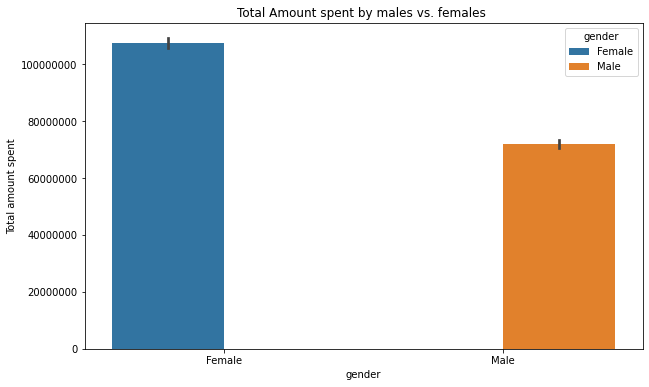

In [87]:
plt.figure(figsize=(10,6))
sns.barplot(df,x='gender',y='total_price',hue = 'gender',estimator = sum)
plt.ylabel('Total amount spent')
plt.title('Total Amount spent by males vs. females ')
plt.ticklabel_format(style='plain',axis='y')
plt.show()

It is evident that the overall total amount of money spent by females is considerably higher. 

Next, we want to comapare the amount of money spent per category by males vs. females 

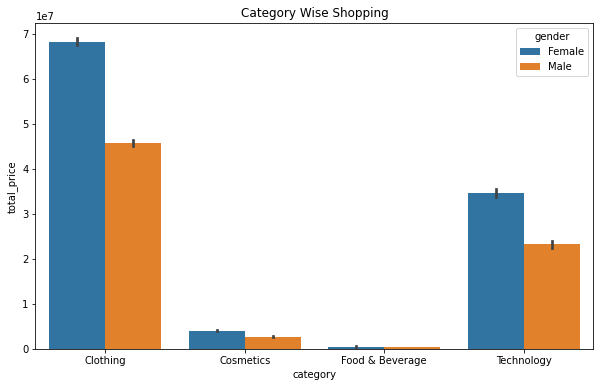

In [88]:
plt.figure(figsize=(10,6))
sns.barplot(df,x='category',y='total_price',hue = 'gender',estimator = sum)
plt.title('Category Wise Shopping')
plt.show()

In [89]:
# checking average price spent by gender per category
avg_price_spent_per=df.groupby(['gender','category'], as_index=False)['total_price'].mean()
avg_age_per=df.groupby(['gender','category'], as_index=False)['age'].mean()
print(avg_price_spent_per)
print("\n",avg_age_per)

   gender         category   total_price
0  Female         Clothing   3304.846775
1  Female        Cosmetics    448.376245
2  Female  Food & Beverage     57.396933
3  Female       Technology  11630.308621
4    Male         Clothing   3306.475999
5    Male        Cosmetics    452.312985
6    Male  Food & Beverage     57.637718
7    Male       Technology  11509.875931

    gender         category        age
0  Female         Clothing  43.381948
1  Female        Cosmetics  43.571665
2  Female  Food & Beverage  43.489209
3  Female       Technology  43.249581
4    Male         Clothing  43.449946
5    Male        Cosmetics  43.594160
6    Male  Food & Beverage  43.155727
7    Male       Technology  43.544417


We quickly find that although there is a lot of difference is total amount spent per category, there is very little difference in when comparing males vs. females within each category. For example, for the Technology category, Males spent an average of 11509.88 Lira wheras females spent 11630.31 Lira and in the Clothing category, males spent an average of 3306.48  Lira whereas females spent an average of 3304.85 Lira. 

### Creating class labels for our dataset 

After visualizing and understanding our dataset, we will now be creating class labels for our dataset. We want to have 3 labels - Yes, No, and Maybe which represent if we should market to this person based on their shopping habits - i.e amount of money spent in a particular category. 

Our cutoffs of creating each of these labels will be based on total cost percentiles per category - 


1. **Yes** - This person's total cost in a certain category is more than the 75 percentile of total money spent in that certain category, therfore, we will defintely want to market to these people. 


2. **Maybe** - This person's total cost in a certain category is less than the 75 percentile but more than the 25 percentile of total money spent in that certain category, therfore, we will may want to market to these people, but will want to give higher priority to people who have spent more money. 


3. **No** -  This person's total cost in a certain category is less than the 25 percentile but more than the median of total money spent in that certain category, therfore, we do not want to market to these people and conserve our resources instead. 

In [90]:
df.groupby(['gender','category'], as_index=False)['total_price'].describe()

gender  0     Female
        1     Female
        2     Female
        3     Female
        4       Male
              ...   
max     3    26250.0
        4     7502.0
        5     1016.5
        6     130.75
        7    26250.0
Length: 80, dtype: object

In [91]:
df.groupby(['gender','category'], as_index=False)['age'].describe()

gender  0    Female
        1    Female
        2    Female
        3    Female
        4      Male
              ...  
max     3      69.0
        4      69.0
        5      69.0
        6      69.0
        7      69.0
Length: 80, dtype: object

In [92]:
# creating the class label
# label -> ['maybe', 'no', 'yes']
def assignNewLabels(row):
    # for book shoppers
    if row['category'] == "Technology" and row["total_price"] > 16800:
        return "yes"
    elif row['category'] == "Technology" and row["total_price"] <= 4200:
        return "no"
    elif row['category'] == "Technology" and row["total_price"] > 4200.0 and row["total_price"] <= 16800:
        return "maybe"
    
    # for clothing
    elif row['category'] == "Clothing" and row["total_price"] > 4801.28:
        return "yes"
    elif row['category'] == "Clothing" and row["total_price"] <= 1200.32:
        return "no"
    elif row['category'] == "Clothing" and row["total_price"] > 1200.32 and row["total_price"] <= 4801.28:
        return "maybe"
    
    # for clothing
    elif row['category'] == "Cosmetics" and row["total_price"] > 650.56:
        return "yes"
    elif row['category'] == "Cosmetics" and row["total_price"] <= 162.64:
        return "no"
    elif row['category'] == "Cosmetics" and row["total_price"] > 162.64 and row["total_price"] <= 650.56:
        return "maybe"
    
    # for clothing
    elif row['category'] == "Food & Beverage" and row["total_price"] > 83.68:
        return "yes"
    elif row['category'] == "Food & Beverage" and row["total_price"] <= 20.92:
        return "no"
    elif row['category'] == "Food & Beverage" and row["total_price"] > 20.92 and row["total_price"] <= 83.68:
        return "maybe"

In [93]:
df['Should_We_Market'] = df.apply(lambda row: assignNewLabels(row), axis=1)
df.head()

,gender,age,category,total_price,Should_We_Market
0,Female,28,Clothing,7502.00,yes
2,Male,20,Clothing,300.08,no
5,Female,28,Clothing,7502.00,yes
6,Female,49,Cosmetics,40.66,no
7,Female,32,Clothing,1200.32,no


### Starting the Machine Learning Process 

We are creating one hot encoded labels for each gender and category features as we are doing multilclass classification. 

In [94]:
df_dummy = pd.get_dummies(df[['gender', 'category', 'age', 'total_price']])
df_dummy.head()


,age,total_price,gender_Female,gender_Male,category_Clothing,category_Cosmetics,category_Food & Beverage,category_Technology
0,28,7502.00,1,0,1,0,0,0
2,20,300.08,0,1,1,0,0,0
5,28,7502.00,1,0,1,0,0,0
6,49,40.66,1,0,0,1,0,0
7,32,1200.32,1,0,1,0,0,0


In [95]:
# converting labels to binary
#from sklearn.preprocessing import MultiLabelBinarizer
#mlb = MultiLabelBinarizer()
#print(mlb.fit_transform(df.Should_We_Market))
#list(mlb.classes_)
#df.head()

In [96]:
df.head()

,gender,age,category,total_price,Should_We_Market
0,Female,28,Clothing,7502.00,yes
2,Male,20,Clothing,300.08,no
5,Female,28,Clothing,7502.00,yes
6,Female,49,Cosmetics,40.66,no
7,Female,32,Clothing,1200.32,no


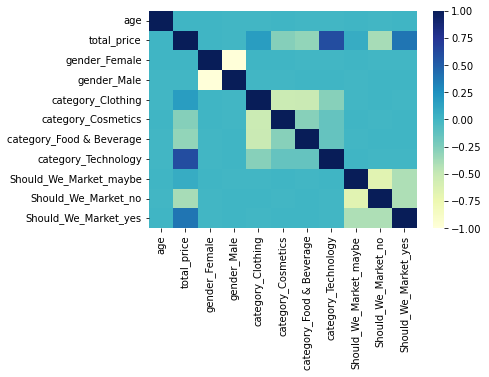

In [97]:
df_dummy_corr = pd.get_dummies(df)
df_dummy_corr.head()
dataplot = sns.heatmap(df_dummy_corr.corr(), cmap="YlGnBu")

  
# displaying heatmap
plt.show()

In [98]:
df_dummy_corr.corr()['Should_We_Market_yes'].sort_values(ascending=False)

Should_We_Market_yes        1.000000
total_price                 0.389312
gender_Male                 0.004875
age                         0.003290
category_Cosmetics          0.000943
category_Food & Beverage    0.000839
category_Technology        -0.000889
category_Clothing          -0.001005
gender_Female              -0.004875
Should_We_Market_no        -0.409166
Should_We_Market_maybe     -0.410114
Name: Should_We_Market_yes, dtype: float64

<Axes: >

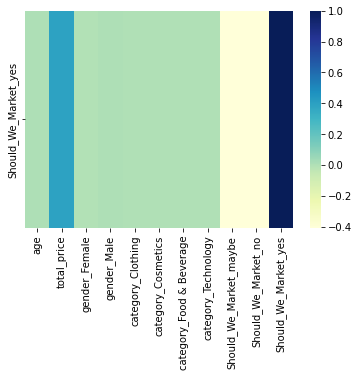

In [99]:
sns.heatmap(df_dummy_corr.corr().loc[['Should_We_Market_yes'],:], cmap="YlGnBu")

In [100]:
X = df_dummy
#y = mlb.fit_transform(df.Should_We_Market)
y = df.Should_We_Market

print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=125
)

(69356, 8) (69356,)


### Gaussian Naive Bayes 

Accuracy: 0.6015341138473961
F1 Score: 0.6578611995943382


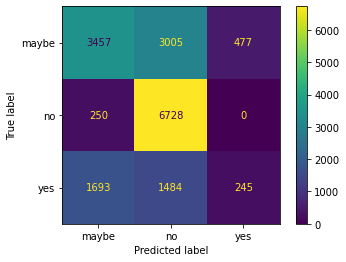

In [101]:
# Build a Gaussian Classifier
model = GaussianNB()

# Model training
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test, average="weighted")

print("Accuracy:", accuracy)
print("F1 Score:", f1)


cm = confusion_matrix(y_test, y_pred, labels=["maybe", "no", "yes"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["maybe", "no", "yes"])
disp.plot();

# interpret results in writeup using https://www.v7labs.com/blog/confusion-matrix-guide

In [102]:
#%pip install imbalanced-learn
import imblearn
from collections import Counter
from numpy import *
import matplotlib.pyplot as plt

In [103]:
counter = Counter(y)
print(counter)

Counter({'maybe': 27724, 'no': 27647, 'yes': 13985})


We can see that accuracy is low, however, yes is the minoirty class which could be causing us to have misaligned weights in the model. 
We will try fixing this using random oversampling techiques. 

In [104]:
from sklearn.utils import resample

# Separate samples by class label
class_labels = df['Should_We_Market'].unique()
class_data = {}
for label in class_labels:
    class_data[label] = df[df['Should_We_Market'] == label]

# Determine the class with the most samples
majority_class = max(class_labels, key=lambda x: len(class_data[x]))

# Oversample the minority class to match the number of samples in the majority class
oversampled_data = []
for label in class_labels:
    if label != majority_class:
        oversampled_data.append(resample(class_data[label], replace=True, n_samples=len(class_data[majority_class])))

# Combine the oversampled data
oversampled_df = pd.concat([class_data[majority_class]] + oversampled_data)

In [105]:
oversampled_df.head()
counter = Counter(oversampled_df["Should_We_Market"])
print(counter)

Counter({'maybe': 27724, 'yes': 27724, 'no': 27724})


In [106]:
over_df_dummy = pd.get_dummies(oversampled_df[['gender', 'category', 'age', 'total_price']])
over_df_dummy.head()


,age,total_price,gender_Female,gender_Male,category_Clothing,category_Cosmetics,category_Food & Beverage,category_Technology
8,69,2700.72,0,1,1,0,0,0
17,42,47.07,1,0,0,0,1,0
29,29,365.94,0,1,0,1,0,0
33,51,4801.28,0,1,1,0,0,0
40,49,47.07,1,0,0,0,1,0


In [107]:
X = over_df_dummy
#y = mlb.fit_transform(df.Should_We_Market)
y = oversampled_df.Should_We_Market

print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=125
)

(83172, 8) (83172,)


### Gaussian Naive Bayes with Oversampling 

Accuracy: 0.6732073293896984
F1 Score: 0.6757967943825477


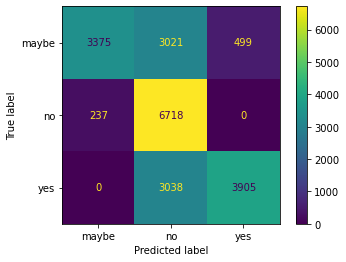

In [108]:
# Build a Gaussian Classifier
model = GaussianNB()

# Model training
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test, average="weighted")

print("Accuracy:", accuracy)
print("F1 Score:", f1)


cm = confusion_matrix(y_test, y_pred, labels=["maybe", "no", "yes"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["maybe", "no", "yes"])
disp.plot();

# interpret results in writeup using https://www.v7labs.com/blog/confusion-matrix-guide

Accuracy went up by 6%! However, we want to fine tune this a bit more. Let's run a random forest classifier to determine how important certain features are, and get rid of unimportant ones.

In [109]:
df.head()

,gender,age,category,total_price,Should_We_Market
0,Female,28,Clothing,7502.00,yes
2,Male,20,Clothing,300.08,no
5,Female,28,Clothing,7502.00,yes
6,Female,49,Cosmetics,40.66,no
7,Female,32,Clothing,1200.32,no


### Random Forest Classifier

In [110]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = over_df_dummy
y = oversampled_df.Should_We_Market

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier()

rf_classifier.fit(X_train, y_train)
Y_pred = rf_classifier.predict(X_test)
acc2 = accuracy_score(y_test, Y_pred)
print(acc2)



fscore = f1_score(y_test, Y_pred, average=None)
print("The F-scores for each class using Random Forest =")
print(fscore) 



# Get feature importances
importances = rf_classifier.feature_importances_

# Sort feature importances in descending order
indices = importances.argsort()[::-1]
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. Feature {X.columns[indices[f]]} ({importances[indices[f]]})")

1.0
The F-scores for each class using Random Forest =
[1. 1. 1.]
Feature ranking:
1. Feature total_price (0.9284082984538562)
2. Feature category_Clothing (0.031790396306665344)
3. Feature category_Technology (0.013754656345802693)
4. Feature category_Food & Beverage (0.013600717502762193)
5. Feature category_Cosmetics (0.010275447803537568)
6. Feature age (0.002026465849112624)
7. Feature gender_Male (7.256147053139138e-05)
8. Feature gender_Female (7.145626773202488e-05)


### Stratified K-fold cross validation for Random Forest

In [111]:
kf = StratifiedKFold(n_splits=10, random_state=40, shuffle=True) 
accscore = []
classifier2 = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 40)


for train_index , test_index in kf.split(X, y):
    X_train , X_test = X.iloc[train_index],X.iloc[test_index]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]
     
    classifier2.fit(X_train, y_train.values.ravel())
    Y_pred = classifier2.predict(X_test)

     
    acc2 = accuracy_score(y_test, Y_pred)
    accscore.append(acc2)
     
avgscore = sum(accscore)/10
 
print("Accuracy from each fold using Random Forest = " + str(accscore))
print("Average accuracy using Random Forest = " + str(avgscore))
print()


Accuracy from each fold using Random Forest = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Average accuracy using Random Forest = 1.0



Looks like Age and Gender don't do much for our model, lets retry without these features! (Still oversampling our original dataset)

In [112]:
over_df_dummy = pd.get_dummies(oversampled_df[['total_price', 'category']])

X = over_df_dummy
#y = mlb.fit_transform(df.Should_We_Market)
y = oversampled_df.Should_We_Market

print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=125
)

(83172, 5) (83172,)


### Gaussian Naive Bayes without unimportant features 

Accuracy: 0.6732073293896984
F1 Score: 0.6757967943825477


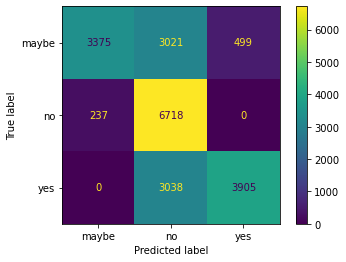

In [113]:
# Build a Gaussian Classifier
model = GaussianNB()

# Model training
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test, average="weighted")

print("Accuracy:", accuracy)
print("F1 Score:", f1)

cm = confusion_matrix(y_test, y_pred, labels=["maybe", "no", "yes"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["maybe", "no", "yes"])
disp.plot();

# interpret results in writeup using https://www.v7labs.com/blog/confusion-matrix-guide

### Stratified K-fold cross validation for oversampled Naive Bayes without Age and Gender features

In [114]:
kf = StratifiedKFold(n_splits=10, random_state=40, shuffle=True) 
accscore = []
classifier2 = GaussianNB()


for train_index , test_index in kf.split(X, y):
    X_train , X_test = X.iloc[train_index],X.iloc[test_index]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]
     
    classifier2.fit(X_train, y_train.values.ravel())
    Y_pred = classifier2.predict(X_test)

     
    acc2 = accuracy_score(y_test, Y_pred)
    accscore.append(acc2)
     
avgscore = sum(accscore)/10
 
print("Accuracy from each fold using oversampled Naive Bayes without Age and Gender features = " + str(accscore))
print("Average accuracy using oversampled Naive Bayes without Age and Gender features = " + str(avgscore))
print()


Accuracy from each fold using oversampled Naive Bayes without Age and Gender features = [0.6749218562154364, 0.6763645106996874, 0.6831790309005651, 0.6784898400865697, 0.6659853312492485, 0.6801731393531322, 0.6792112540579536, 0.6771672478056991, 0.6846218588433329, 0.6707947577251413]
Average accuracy using oversampled Naive Bayes without Age and Gender features = 0.6770908826936767



Hmmm, seems like the age and gender features really did not matter in the long run. Lets try another classification technique instead!

### Neural Networks:

In [ ]:
from sklearn.neural_network import MLPClassifier

## Conclusion

## Policy Recommendation 
The performance of these models could be improved by: 